#Settings

##Imports

In [1]:
%%capture
!pip install datasets
!pip install transformers
!pip install wandb

In [2]:
import numpy as np
import random
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchtext
import sys
import seaborn as sns
import os
from functools import partial
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support,  f1_score, roc_auc_score, accuracy_score, multilabel_confusion_matrix, ConfusionMatrixDisplay, hamming_loss
import datasets 
from transformers import BertTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EvalPrediction, AutoTokenizer,EarlyStoppingCallback, IntervalStrategy,integrations, pipeline
import wandb

## W&B initialization

Here we login to Weight&Biases and set up some base saving options.

In [3]:
# set the wandb project where this run will be logged, organize runs by project with the WANDB_PROJECT environment variable
#PROJECT NAME
os.environ["WANDB_PROJECT"]="Human_Value_1"
# save your trained model checkpoint to wandb, auto-logging of models as artifacts: just set environment varilable WANDB_LOG_MODEL to true
os.environ["WANDB_LOG_MODEL"]="true"
# turn off watch to log faster,log histograms of gradients and parameters: 
#by default gradients are logged, you can also log parameters by setting environment variable WANDB_WATCH to all
os.environ["WANDB_WATCH"]="all"

In [4]:
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Reproducibility

In [5]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use. 
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    %env CUBLAS_WORKSPACE_CONFIG=:4096:8
    
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_random(seed=42)


env: CUBLAS_WORKSPACE_CONFIG=:4096:8


## Runtime Settings

Let's check that our  environment has the proper configuration.

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"{device} selected")

cuda selected


The mount is needed to save data in drive and avoing long runtime restarts. Moreover since we are using the nootebok also with a local runtime we have to make sure that it does not try to connect to drive when it can't.

In [7]:
if 'google.colab' in sys.modules:
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


here we define where will our model output

In [8]:
if 'google.colab' in sys.modules:
    dir = "/content/Content_model"
else: 
    dir = "H:/My Drive/Uni/Uni/NLP/NLP_Project/Content_model"


#Preprocessing

##Data Upload

In [16]:
if 'google.colab' in sys.modules:
  folder_path = os.path.join(
                  os.getcwd(),
                  "drive",
                  "MyDrive",
                  "NLP_Project",
                  "Dataset")
  arguments_train = pd.read_csv(f"{folder_path}/arguments-training.tsv", sep = "\t")
  arguments_val = pd.read_csv(f"{folder_path}/arguments-validation.tsv", sep = "\t")
  arguments_zhihu = pd.read_csv(f"{folder_path}/arguments-validation-zhihu.tsv", sep = "\t")
  labels_train = pd.read_csv(f"{folder_path}/labels-training.tsv", sep = "\t")
  labels_val = pd.read_csv(f"{folder_path}/labels-validation.tsv", sep = "\t")
  labels_zhihu = pd.read_csv(f"{folder_path}/labels-validation-zhihu.tsv", sep = "\t")

else:
  arguments_train = pd.read_csv("H:/My Drive/Uni/Uni/NLP/NLP_Project/Dataset/arguments-training.tsv", sep = "\t")
  arguments_val = pd.read_csv("H:/My Drive/Uni/Uni/NLP/NLP_Project/Dataset/arguments-validation.tsv", sep = "\t")
  arguments_zhihu = pd.read_csv("H:/My Drive/Uni/Uni/NLP/NLP_Project/Dataset/arguments-validation-zhihu.tsv", sep = "\t")
  labels_train = pd.read_csv("H:/My Drive/Uni/Uni/NLP/NLP_Project/Dataset/labels-training.tsv", sep = "\t")
  labels_val = pd.read_csv("H:/My Drive/Uni/Uni/NLP/NLP_Project/Dataset/labels-validation.tsv", sep = "\t")
  labels_zhihu = pd.read_csv("H:/My Drive/Uni/Uni/NLP/NLP_Project/Dataset/labels-validation-zhihu.tsv", sep = "\t")
  



In [17]:
arguments_train

,Argument ID,Conclusion,Stance,Premise
0,A01001,Entrapment should be legalized,in favor of,if entrapment can serve to more easily capture...
1,A01002,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...
2,A01003,We should abandon marriage,against,marriage is the ultimate commitment to someone...
3,A01004,We should ban naturopathy,against,it provides a useful income for some people
4,A01005,We should ban fast food,in favor of,fast food should be banned because it is reall...
...,...,...,...,...
5215,D27096,Nepotism exists in Bollywood,against,Star kids also have an upbringing which is sur...
5216,D27097,Nepotism exists in Bollywood,in favor of,Movie stars of Bollywood often launch their ch...
5217,D27098,India is safe for women,in favor of,Evil historic practices on women in the pre an...
5218,D27099,India is safe for women,in favor of,Women of our country have been and are achievi...


In [18]:
labels_train.head()

,Argument ID,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,Power: resources,Face,Security: personal,...,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,A01001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,A01002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,A01003,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,A01004,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,A01005,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


## Test split

Since we are not given labels for the test split, we will extract a new test split from our validation set.

In [19]:
arguments_val, arguments_test, labels_val, labels_test = train_test_split(arguments_val, labels_val, test_size=0.2)

##Data Visualization

### Labels distribution

In [20]:
unique_labels = labels_train.columns[1:]
unique_labels

Index(['Self-direction: thought', 'Self-direction: action', 'Stimulation',
       'Hedonism', 'Achievement', 'Power: dominance', 'Power: resources',
       'Face', 'Security: personal', 'Security: societal', 'Tradition',
       'Conformity: rules', 'Conformity: interpersonal', 'Humility',
       'Benevolence: caring', 'Benevolence: dependability',
       'Universalism: concern', 'Universalism: nature',
       'Universalism: tolerance', 'Universalism: objectivity'],
      dtype='object')

Here a mapping between labels (and vice versa) and their position in the dataframe is created. It will be later used by Huggingsface's Trainer.

In [21]:
labels = unique_labels.to_list()
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}
label2id

{'Self-direction: thought': 0,
 'Self-direction: action': 1,
 'Stimulation': 2,
 'Hedonism': 3,
 'Achievement': 4,
 'Power: dominance': 5,
 'Power: resources': 6,
 'Face': 7,
 'Security: personal': 8,
 'Security: societal': 9,
 'Tradition': 10,
 'Conformity: rules': 11,
 'Conformity: interpersonal': 12,
 'Humility': 13,
 'Benevolence: caring': 14,
 'Benevolence: dependability': 15,
 'Universalism: concern': 16,
 'Universalism: nature': 17,
 'Universalism: tolerance': 18,
 'Universalism: objectivity': 19}

In [22]:
labels_train_count = (labels_train.sum()[1:]/len(labels_train)).tolist()
labels_val_count = (labels_val.sum()[1:]/len(labels_val)).tolist()
labels_test_count = (labels_test.sum()[1:]/len(labels_test)).tolist()

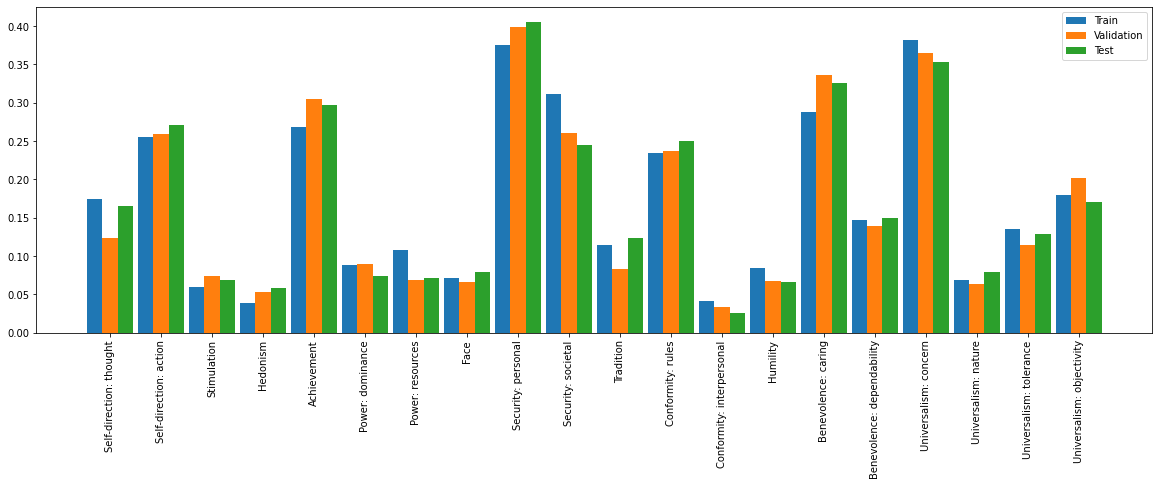

In [23]:
plt.figure(figsize=(20,6))
X_axis = np.arange(len(unique_labels))
plt.bar(X_axis -0.3 ,  labels_train_count, 0.3, label = "Train")
plt.bar(X_axis,  labels_val_count, 0.3, label = "Validation")
plt.bar(X_axis + 0.3,  labels_test_count, 0.3, label = "Test")
plt.xticks(X_axis, unique_labels , rotation = "vertical")
plt.legend();

It is possible to the that there is no imbalance between splits, there is however some class imbalance. We will deal with this problem with a custom loss function.

### Lengths distribution

In [24]:
def get_length_of_premise_and_conclusion(x):
  return {'premise_lenght': len(x['Premise'].split(' ')),
          'conclusion_length': len(x['Conclusion'].split(' '))}

In [25]:
train_lengths = arguments_train.apply(get_length_of_premise_and_conclusion, axis=1, result_type='expand')
train_lengths.describe(percentiles=[0.25, 0.50, 0.75, 0.85, 0.9, 0.95, 0.99])

,premise_lenght,conclusion_length
count,5220.000000,5220.000000
mean,18.910536,5.635057
std,8.174744,1.479488
min,3.000000,4.000000
25%,13.000000,5.000000
50%,18.000000,5.000000
75%,24.000000,7.000000
85%,28.000000,7.000000
90%,30.000000,8.000000
95%,33.000000,8.000000


In [26]:
val_lengths = arguments_val.apply(get_length_of_premise_and_conclusion, axis=1, result_type='expand')
val_lengths.describe(percentiles=[0.25, 0.50, 0.75, 0.85, 0.9, 0.95, 0.99])

,premise_lenght,conclusion_length
count,1516.000000,1516.000000
mean,22.195251,6.621372
std,12.904478,2.392876
min,5.000000,4.000000
25%,14.000000,5.000000
50%,19.000000,7.000000
75%,27.000000,7.000000
85%,32.000000,8.000000
90%,35.000000,8.000000
95%,44.000000,11.000000


In [27]:
test_lengths = arguments_test.apply(get_length_of_premise_and_conclusion, axis=1, result_type='expand')
test_lengths.describe(percentiles=[0.25, 0.50, 0.75, 0.85, 0.9, 0.95, 0.99])

,premise_lenght,conclusion_length
count,380.000000,380.000000
mean,21.384211,6.563158
std,12.883270,2.402442
min,5.000000,4.000000
25%,13.000000,5.000000
50%,18.000000,7.000000
75%,26.000000,7.000000
85%,31.000000,8.000000
90%,36.100000,8.000000
95%,43.000000,10.000000


The lenght of different premises seems to be very different. By not taking any action we would probably end up with the large majority of examples having a not needed padding. To overcome this problem we could exclude/truncate the few examples that have a very long premise. To decide the maximum length we will wait to compare the tokenized verrsions' lengths.

## Data manipulation

### Labels casting

In order to feed the labels to the network, we need to cast them to float

In [28]:
labels_train.iloc[:, 1:] = labels_train.iloc[:, 1:].astype(np.float32)
labels_val.iloc[:, 1:] = labels_val.iloc[:, 1:].astype(np.float32)
labels_test.iloc[:, 1:] = labels_test.iloc[:, 1:].astype(np.float32)
labels_zhihu.iloc[:, 1:] = labels_zhihu.iloc[:, 1:].astype(np.float32)
labels_train.head()

,Argument ID,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,Power: resources,Face,Security: personal,...,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,A01001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,A01002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,A01003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,A01004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A01005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Joining dataframes

In [29]:
train_df = arguments_train.set_index('Argument ID').join(labels_train.set_index('Argument ID'))
val_df = arguments_val.set_index('Argument ID').join(labels_val.set_index('Argument ID'))
test_df = arguments_test.set_index('Argument ID').join(labels_test.set_index('Argument ID'))
zhihu_df = arguments_zhihu.set_index('Argument ID').join(labels_zhihu.set_index('Argument ID'))
train_df


,Conclusion,Stance,Premise,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,Power: resources,...,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
Argument ID,,,,,,,,,,,,,,,,,,,,,
A01001,Entrapment should be legalized,in favor of,if entrapment can serve to more easily capture...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A01002,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A01003,We should abandon marriage,against,marriage is the ultimate commitment to someone...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A01004,We should ban naturopathy,against,it provides a useful income for some people,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A01005,We should ban fast food,in favor of,fast food should be banned because it is reall...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D27096,Nepotism exists in Bollywood,against,Star kids also have an upbringing which is sur...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D27097,Nepotism exists in Bollywood,in favor of,Movie stars of Bollywood often launch their ch...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
D27098,India is safe for women,in favor of,Evil historic practices on women in the pre an...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Creating datasets

In [30]:
train_ds = datasets.Dataset.from_pandas(train_df)
val_ds = datasets.Dataset.from_pandas(val_df)
test_ds = datasets.Dataset.from_pandas(test_df)
zhihu_ds = datasets.Dataset.from_pandas(zhihu_df)

In [31]:
train_ds[0]

{'Conclusion': 'Entrapment should be legalized',
 'Stance': 'in favor of',
 'Premise': "if entrapment can serve to more easily capture wanted criminals, then why shouldn't it be legal?",
 'Self-direction: thought': 0.0,
 'Self-direction: action': 0.0,
 'Stimulation': 0.0,
 'Hedonism': 0.0,
 'Achievement': 0.0,
 'Power: dominance': 0.0,
 'Power: resources': 0.0,
 'Face': 0.0,
 'Security: personal': 0.0,
 'Security: societal': 1.0,
 'Tradition': 0.0,
 'Conformity: rules': 0.0,
 'Conformity: interpersonal': 0.0,
 'Humility': 0.0,
 'Benevolence: caring': 0.0,
 'Benevolence: dependability': 0.0,
 'Universalism: concern': 0.0,
 'Universalism: nature': 0.0,
 'Universalism: tolerance': 0.0,
 'Universalism: objectivity': 0.0,
 'Argument ID': 'A01001'}

# Hyperparameters

The idea is to keep all hyperparameters explicitly defined here. this allows to have a clear look at them and also to send them in a good way to wandb. 

In [ ]:
# To update config of old runs
# api = wandb.Api()

# run = api.run("4projects/Human_Value_1/r7w7o7w6")
# run.config["loss"] = 'bce'
# run.update()

In [43]:
# The parameters for the base run are the one from the paper of kiesel
# batch size of 8, lr of 2e-5, 20 epochs, constant scheduler, no class weights and no weight decay and no bias init
RUN_NAME = "distilbert_base_2"  #cambiatela ogni volta mariuoli
BATCH_SIZE = 8 
LEARNING_RATE = 2e-5
ARCHITECTURE = 'distilbert-base-uncased'
EPOCHS = 30
PATIENCE = 4
LOSS = 'bce' # Possible choices are 'bce', 'weighted' and 'db'
WEIGHT_DECAY = 0
LR_SCHEDULER = 'constant'
BIAS_INIT = False



In [ ]:
wandb.init(project= "Human_Value_1", name = RUN_NAME, group='main',
           config = {"epochs": EPOCHS, "batch_size": BATCH_SIZE, "architecture" : ARCHITECTURE, 
                     "lr" : 2e-5, "patience" : PATIENCE, 'loss': LOSS, 
                     'weight_decay': WEIGHT_DECAY, 'lr_scheduler': LR_SCHEDULER})


In [ ]:
#wandb.finish()

# Data tokenization

We will first tokenize the data using the max length possible that BertTokenizer allows us. Afterwards, we will check the distribution of the lengths of the tokenized train examples and decide for a more efficient maximum length

### Utils

The following two function accomplish two things, tokenization and adding the labels to the encoding.
At first we were under the impression that **tokenizer** could accept an unlimited number of imputs, however when visualizing the tokenized sentences we realized that Premises where being cut out as it was actually only accepting the first two imputs. 
For this reason Premise, Conclusion and Stance have been put togheter separated by *sep_token* and feed as a single imput. 

In [47]:
def convertTuple(tup):
    st = ' '.join(map(str, tup))
    return st 

In [48]:
tokenizer = AutoTokenizer.from_pretrained(ARCHITECTURE)

def preprocess_data(max_length, examples):
  # encode them
  length = len(examples["Premise"])
  sep = [tokenizer.sep_token for x in range(length)]

  a = list(zip(examples["Conclusion"], sep, examples["Stance"], sep, examples["Premise"]))
  text = [convertTuple(item) for item in a]
  encoding = tokenizer(text,
                       padding="max_length", 
                       truncation=True,
                       max_length=max_length)
  # add labels
  labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
  # create numpy array of shape (batch_size, num_labels)
  
  labels_matrix = np.zeros( (length, len(labels)) )
  # fill numpy array
  for idx, label in enumerate(labels):
    labels_matrix[:, idx] = labels_batch[label]

  encoding["labels"] = labels_matrix.tolist()
  
  return encoding

### Long tokenization

This first tokenization aims at understaning how much padding is needed.

In [49]:
long_tokenized_train_ds = train_ds.map(
    partial(preprocess_data, 512),
    batched=True,
    remove_columns = train_ds.column_names
)


  0%|          | 0/6 [00:00<?, ?ba/s]

Qua controlliamo che la sequenza stia arrivando con un senso, prima la conclusion non c'era

In [50]:
example = long_tokenized_train_ds[3]
tokenizer.decode(example['input_ids'])

'[CLS] we should ban naturopathy [SEP] against [SEP] it provides a useful income for some people [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

In [51]:
train_tokenized_lengths = [sum(x) for x in long_tokenized_train_ds['attention_mask']]
print(f'The maximum tokenized lenght is {np.max(train_tokenized_lengths)}')
percentiles = np.percentile(train_tokenized_lengths, q=[50, 75, 85, 90, 95, 99])
print('The 50, 75, 85, 90, 95 and 99 percentiles are the following:')
print(percentiles)

The maximum tokenized lenght is 173
The 50, 75, 85, 90, 95 and 99 percentiles are the following:
[33. 40. 45. 48. 52. 60.]


This means that we could keep 60 as maximum length and the 99% of our training examples would not be truncated. This would make the training process much faster without altering its validity.

### Short tokenization

Now that we have defined a suitable lenght we proceede to tokenize the rest of the data.

In [52]:
tokenized_train_ds = train_ds.map(
    partial(preprocess_data, int(percentiles[-1])),
    batched=True,
    remove_columns = train_ds.column_names
)

  0%|          | 0/6 [00:00<?, ?ba/s]

In [53]:
tokenized_train_ds.set_format(
    "torch",
    columns = ["input_ids", "attention_mask", "labels"],
    # device = device
)

In [54]:
tokenized_val_ds = val_ds.map(
    partial(preprocess_data, 60),
    batched=True,
    remove_columns = val_ds.column_names
)

  0%|          | 0/2 [00:00<?, ?ba/s]

In [55]:
tokenized_val_ds.set_format(
    "torch",
    columns = ["input_ids", "attention_mask", "labels"],
    #  device= device
)

In [56]:
tokenized_test_ds = test_ds.map(
    partial(preprocess_data, 60),
    batched=True,
    remove_columns = test_ds.column_names
)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [57]:
tokenized_test_ds.set_format(
    "torch",
    columns = ["input_ids", "attention_mask", "labels"],
    device = device 
)

In [58]:
tokenized_test_ds_eval = test_ds.map(
    partial(preprocess_data, 60),
    batched=True,
    remove_columns = test_ds.column_names
)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [59]:
tokenized_test_ds_eval.set_format(
    "torch",
    columns = ["input_ids", "attention_mask", "labels"],
)

In [60]:
tokenized_zhihu_ds = zhihu_ds.map(
    partial(preprocess_data, 60),
    batched=True,
    remove_columns = test_ds.column_names
)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [61]:
tokenized_zhihu_ds.set_format(
    "torch",
    columns = ["input_ids", "attention_mask", "labels"],
)

#Metrics

In [35]:
# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    f1_macro_average = f1_score(y_true=y_true, y_pred=y_pred, average='macro')
    prec, recall, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average='macro' )
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    hamming = hamming_loss(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               "fi_macro" : f1_macro,
               "precision" : prec,
               "recall" : recall, 
               'roc_auc': roc_auc,
               'accuracy': accuracy,
               'hamming' : hamming 
               
}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        labels=p.label_ids)
    return result

ex_pred = [[1, 0, 0], [0,1,1]]
ex_labels = [[1, 1, 0], [0,0,1]]

multi_label_metrics(ex_pred, ex_labels)

{'f1': 0.6666666666666666,
 'fi_macro': 0.6666666666666666,
 'precision': 0.5,
 'recall': 1.0,
 'roc_auc': 0.5,
 'accuracy': 0.0,
 'hamming': 0.5}

# Baseline

We will have a very simple baselines. 

- **Baseline-1**: Classifies each argument as resorting
to all values. Thus always achieves a recall of 1.

The first is the one used in the [paper](https://webis.de/downloads/publications/papers/kiesel_2022b.pdf) from which this project is inspired.

AGGIUSTATO PRENDENDO I LABELS AGGREGATI DALL'OUTPUT DI PREPROCESSING

## Baseline-1

In [ ]:
baseline_1_val = val_df.copy()
lab = tokenized_val_ds["labels"] 
scores = [np.ones((20,), dtype=int) for _ in range(len(baseline_1_val))]
baseline_1_val['scores'] = scores

In [ ]:
y_true = np.array(lab.tolist()).astype(int)
y_pred = np.array(baseline_1_val['scores'].tolist())

prec, rec, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
f1_micro = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
hamming = hamming_loss(y_true, y_pred)

print(f'Baseline 1 in the validation set produced the following results:\nPrecision: {prec}\nRecall: {rec}\nF1 macro: {f1_macro}\nF1 micro: {f1_micro}\nRoc auc score: {roc_auc}\nHamming: {hamming}')

Baseline 1 in the validation set produced the following results:
Precision: 0.1670184696569921
Recall: 1.0
F1 macro: 0.2705098725606561
F1 micro: 0.286231064888085
Roc auc score: 0.5
Hamming: 0.8329815303430079


In [ ]:
baseline_1_test = test_df.copy()
lab_test = tokenized_test_ds["labels"]
scores = [np.ones((20,), dtype=int) for _ in range(len(baseline_1_test))]
baseline_1_test['scores'] = scores

In [ ]:
y_true = np.array(lab_test.tolist()).astype(int)
y_pred = np.array(baseline_1_test['scores'].tolist())

prec, rec, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
f1_micro = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
hamming = hamming_loss(y_true, y_pred)

print(f'Baseline 1 in the test set produced the following results:\nPrecision: {prec}\nRecall: {rec}\nF1 macro: {f1_macro}\nF1 micro: {f1_micro}\nRoc auc score: {roc_auc}\nHamming: {hamming}')

Baseline 1 in the test set produced the following results:
Precision: 0.17039473684210527
Recall: 1.0
F1 macro: 0.2764645365193959
F1 micro: 0.29117481731309725
Roc auc score: 0.5
Hamming: 0.8296052631578947


# Losses

## BCE with logits

In [36]:
bce_loss = torch.nn.BCEWithLogitsLoss()

## Weighted_loss

Here we calculate the weights for each class and crate a custom loss function. It has been immediatly possible to see the effect of it because of the decreased difference between the f1 macro and micro scoore. 

In [37]:
weights = 1 - np.array(labels_train_count)

weighted_loss = torch.nn.BCEWithLogitsLoss(weight=torch.tensor(weights).to(device))

##  Distribution-balanced loss

In [38]:
class ResampleLoss(nn.Module):

    def __init__(self,
                 use_sigmoid=True, partial=False,
                 loss_weight=1.0, reduction='mean',
                 reweight_func=None,  # None, 'inv', 'sqrt_inv', 'rebalance', 'CB'
                 weight_norm=None, # None, 'by_instance', 'by_batch'
                 focal=dict(
                     focal=True,
                     alpha=0.5,
                     gamma=2,
                 ),
                 map_param=dict(
                     alpha=10.0,
                     beta=0.2,
                     gamma=0.1
                 ),
                 CB_loss=dict(
                     CB_beta=0.9,
                     CB_mode='average_w'  # 'by_class', 'average_n', 'average_w', 'min_n'
                 ),
                 logit_reg=dict(
                     neg_scale=5.0,
                     init_bias=0.1
                 ),
                 class_freq=None,
                 train_num=None):
        super(ResampleLoss, self).__init__()

        assert (use_sigmoid is True) or (partial is False)
        self.use_sigmoid = use_sigmoid
        self.partial = partial
        self.loss_weight = loss_weight
        self.reduction = reduction
        if self.use_sigmoid:
            if self.partial:
                self.cls_criterion = partial_cross_entropy
            else:
                self.cls_criterion = binary_cross_entropy
        else:
            self.cls_criterion = cross_entropy

        # reweighting function
        self.reweight_func = reweight_func

        # normalization (optional)
        self.weight_norm = weight_norm

        # focal loss params
        self.focal = focal['focal']
        self.gamma = focal['gamma']
        self.alpha = focal['alpha'] # change to alpha

        # mapping function params
        self.map_alpha = map_param['alpha']
        self.map_beta = map_param['beta']
        self.map_gamma = map_param['gamma']

        # CB loss params (optional)
        self.CB_beta = CB_loss['CB_beta']
        self.CB_mode = CB_loss['CB_mode']

        self.class_freq = torch.from_numpy(np.asarray(class_freq)).float().cuda()
        self.num_classes = self.class_freq.shape[0]
        self.train_num = train_num # only used to be divided by class_freq
        # regularization params
        self.logit_reg = logit_reg
        self.neg_scale = logit_reg[
            'neg_scale'] if 'neg_scale' in logit_reg else 1.0
        init_bias = logit_reg['init_bias'] if 'init_bias' in logit_reg else 0.0
        self.init_bias = - torch.log(
            self.train_num / self.class_freq - 1) * init_bias ########################## bug fixed https://github.com/wutong16/DistributionBalancedLoss/issues/8

        self.freq_inv = torch.ones(self.class_freq.shape).cuda() / self.class_freq
        self.propotion_inv = self.train_num / self.class_freq

    def forward(self,
                cls_score,
                label,
                weight=None,
                avg_factor=None,
                reduction_override=None,
                **kwargs):

        assert reduction_override in (None, 'none', 'mean', 'sum')
        reduction = (
            reduction_override if reduction_override else self.reduction)

        weight = self.reweight_functions(label)

        cls_score, weight = self.logit_reg_functions(label.float(), cls_score, weight)

        if self.focal:
            logpt = self.cls_criterion(
                cls_score.clone(), label, weight=None, reduction='none',
                avg_factor=avg_factor)
            # pt is sigmoid(logit) for pos or sigmoid(-logit) for neg
            pt = torch.exp(-logpt)
            wtloss = self.cls_criterion(
                cls_score, label.float(), weight=weight, reduction='none')
            alpha_t = torch.where(label==1, self.alpha, 1-self.alpha)
            loss = alpha_t * ((1 - pt) ** self.gamma) * wtloss ####################### balance_param should be a tensor
            loss = reduce_loss(loss, reduction)             ############################ add reduction
        else:
            loss = self.cls_criterion(cls_score, label.float(), weight,
                                      reduction=reduction)

        loss = self.loss_weight * loss
        return loss

    def reweight_functions(self, label):
        if self.reweight_func is None:
            return None
        elif self.reweight_func in ['inv', 'sqrt_inv']:
            weight = self.RW_weight(label.float())
        elif self.reweight_func in 'rebalance':
            weight = self.rebalance_weight(label.float())
        elif self.reweight_func in 'CB':
            weight = self.CB_weight(label.float())
        else:
            return None

        if self.weight_norm is not None:
            if 'by_instance' in self.weight_norm:
                max_by_instance, _ = torch.max(weight, dim=-1, keepdim=True)
                weight = weight / max_by_instance
            elif 'by_batch' in self.weight_norm:
                weight = weight / torch.max(weight)

        return weight

    def logit_reg_functions(self, labels, logits, weight=None): 
        if not self.logit_reg:
            return logits, weight
        if 'init_bias' in self.logit_reg:
            logits += self.init_bias
        if 'neg_scale' in self.logit_reg:
            logits = logits * (1 - labels) * self.neg_scale  + logits * labels
            if weight is not None:
                weight = weight / self.neg_scale * (1 - labels) + weight * labels
        return logits, weight

    def rebalance_weight(self, gt_labels):
        repeat_rate = torch.sum( gt_labels.float() * self.freq_inv, dim=1, keepdim=True)
        pos_weight = self.freq_inv.clone().detach().unsqueeze(0) / repeat_rate
        # pos and neg are equally treated
        weight = torch.sigmoid(self.map_beta * (pos_weight - self.map_gamma)) + self.map_alpha
        return weight

    def CB_weight(self, gt_labels):
        if  'by_class' in self.CB_mode:
            weight = torch.tensor((1 - self.CB_beta)).cuda() / \
                     (1 - torch.pow(self.CB_beta, self.class_freq)).cuda()
        elif 'average_n' in self.CB_mode:
            avg_n = torch.sum(gt_labels * self.class_freq, dim=1, keepdim=True) / \
                    torch.sum(gt_labels, dim=1, keepdim=True)
            weight = torch.tensor((1 - self.CB_beta)).cuda() / \
                     (1 - torch.pow(self.CB_beta, avg_n)).cuda()
        elif 'average_w' in self.CB_mode:
            weight_ = torch.tensor((1 - self.CB_beta)).cuda() / \
                      (1 - torch.pow(self.CB_beta, self.class_freq)).cuda()
            weight = torch.sum(gt_labels * weight_, dim=1, keepdim=True) / \
                     torch.sum(gt_labels, dim=1, keepdim=True)
        elif 'min_n' in self.CB_mode:
            min_n, _ = torch.min(gt_labels * self.class_freq +
                                 (1 - gt_labels) * 100000, dim=1, keepdim=True)
            weight = torch.tensor((1 - self.CB_beta)).cuda() / \
                     (1 - torch.pow(self.CB_beta, min_n)).cuda()
        else:
            raise NameError
        return weight

    def RW_weight(self, gt_labels, by_class=True):
        if 'sqrt' in self.reweight_func:
            weight = torch.sqrt(self.propotion_inv)
        else:
            weight = self.propotion_inv
        if not by_class:
            sum_ = torch.sum(weight * gt_labels, dim=1, keepdim=True)
            weight = sum_ / torch.sum(gt_labels, dim=1, keepdim=True)
        return weight
    

def reduce_loss(loss, reduction):
    """Reduce loss as specified.
    Args:
        loss (Tensor): Elementwise loss tensor.
        reduction (str): Options are "none", "mean" and "sum".
    Return:
        Tensor: Reduced loss tensor.
    """
    reduction_enum = F._Reduction.get_enum(reduction)
    # none: 0, elementwise_mean:1, sum: 2
    if reduction_enum == 0:
        return loss
    elif reduction_enum == 1:
        return loss.mean()
    elif reduction_enum == 2:
        return loss.sum()


def weight_reduce_loss(loss, weight=None, reduction='mean', avg_factor=None):
    """Apply element-wise weight and reduce loss.
    Args:
        loss (Tensor): Element-wise loss.
        weight (Tensor): Element-wise weights.
        reduction (str): Same as built-in losses of PyTorch.
        avg_factor (float): Avarage factor when computing the mean of losses.
    Returns:
        Tensor: Processed loss values.
    """
    # if weight is specified, apply element-wise weight
    if weight is not None:
        loss = loss * weight

    # if avg_factor is not specified, just reduce the loss
    if avg_factor is None:
        loss = reduce_loss(loss, reduction)
    else:
        # if reduction is mean, then average the loss by avg_factor
        if reduction == 'mean':
            loss = loss.sum() / avg_factor
        # if reduction is 'none', then do nothing, otherwise raise an error
        elif reduction != 'none':
            raise ValueError('avg_factor can not be used with reduction="sum"')
    return loss


def binary_cross_entropy(pred,
                         label,
                         weight=None,
                         reduction='mean',
                         avg_factor=None):

    # weighted element-wise losses
    if weight is not None:
        weight = weight.float()

    loss = F.binary_cross_entropy_with_logits(
        pred, label.float(), weight, reduction='none')
    loss = weight_reduce_loss(loss, reduction=reduction, avg_factor=avg_factor)

    return loss


In [39]:
lab_frequency_train = (labels_train.sum()[1:]).tolist()


db_loss = ResampleLoss(reweight_func='rebalance', loss_weight=1.0,
                             focal=dict(focal=True, alpha=0.5, gamma=2),
                             logit_reg=dict(init_bias=0.05, neg_scale=2.0),
                             map_param=dict(alpha=0.1, beta=10.0, gamma=0.05), 
                             class_freq=lab_frequency_train, train_num=len(train_ds))

In [40]:
loss_dict = {'bce': bce_loss,
             'weighted': weighted_loss,
             'db': db_loss}

# Experiment

## Architechture

Using huggingface to download and deploy pretrained models seemed the right thing to do.

In [ ]:
%%capture
model = AutoModelForSequenceClassification.from_pretrained(
    ARCHITECTURE,
    num_labels=20,
    problem_type="multi_label_classification",
    id2label=id2label,
    label2id=label2id
).to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
for name, param in model.named_parameters():
     print(name, param.requires_grad)

## Bias Initialization

The bias of the classification layer should be initialized, for each class, with its probability to be true. This is inspired by Karpati's blog.

In [ ]:
bias = -np.log( 1/np.array(labels_train_count) - 1)    
bias

array([-1.551261  , -1.07121331, -2.75561862, -3.21251903, -1.00377819,
       -2.3343948 , -2.10688827, -2.5616531 , -0.50796585, -0.79224968,
       -2.04499204, -1.18530538, -3.13789566, -2.39039524, -0.90825856,
       -1.76037568, -0.48272359, -2.60867217, -1.85041861, -1.5197257 ])

In [ ]:
if BIAS_INIT:
  model.classifier.bias = torch.nn.Parameter(torch.tensor(bias, dtype=torch.float32).to(device))

## Training args

In [44]:
training_args = TrainingArguments(
    dir,
    do_train = True,
    do_eval=True,
    evaluation_strategy="steps",
    eval_steps = 500,
    per_device_eval_batch_size=len(val_ds),
    learning_rate= LEARNING_RATE ,
    save_strategy="steps",
    save_steps=2000,
    load_best_model_at_end = True, #W&B will save the best performing model checkpoint to Artifacts instead of the final checkpoint.
    metric_for_best_model = 'f1',
    report_to="wandb",
    logging_steps=5,
    run_name = RUN_NAME,  # name of the W&B run (optional)
    num_train_epochs= EPOCHS,
    per_device_train_batch_size= BATCH_SIZE,
    lr_scheduler_type=LR_SCHEDULER,
    weight_decay=WEIGHT_DECAY,
    fp16 = True
) 

## Loss

A custom trainer is needed to implement our other loss functions.

In [45]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has 3 labels with different weights)
        loss_fct = loss_dict[LOSS]
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels)
        return (loss, outputs) if return_outputs else loss

## Training

In [62]:
trainer = CustomTrainer(
    model = model, 
    args = training_args,
    train_dataset = tokenized_train_ds,
    eval_dataset = tokenized_val_ds,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=PATIENCE)]
)

Setting `WANDB_LOG_MODEL` from true to `end` instead
Using cuda_amp half precision backend


In [ ]:
trainer.train()


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 5220
  Num Epochs = 30
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19590
  Number of trainable parameters = 66968852
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Step,Training Loss,Validation Loss,F1,Fi Macro,Precision,Recall,Roc Auc,Accuracy,Hamming
500,0.347700,0.352428,0.352043,0.146355,0.329486,0.120356,0.607383,0.050132,0.142777
1000,0.320300,0.318657,0.490235,0.289883,0.489683,0.237449,0.670878,0.097625,0.128265
1500,0.290500,0.298426,0.556570,0.358172,0.547475,0.301193,0.708547,0.108179,0.120086
2000,0.224900,0.282905,0.583078,0.383993,0.585718,0.326530,0.720797,0.133905,0.112302
2500,0.234200,0.265763,0.630211,0.487760,0.782926,0.413147,0.748877,0.164248,0.103265
3000,0.234100,0.255676,0.661470,0.528716,0.792946,0.455320,0.769531,0.186016,0.097394
3500,0.195300,0.245707,0.691372,0.570103,0.793523,0.493828,0.789988,0.236148,0.091194
4000,0.153300,0.241200,0.704892,0.591566,0.804571,0.511248,0.796134,0.262533,0.086741
4500,0.129000,0.235410,0.723952,0.622784,0.804038,0.544775,0.810291,0.302770,0.082751
5000,0.120500,0.233340,0.742273,0.654229,0.832347,0.567612,0.820208,0.335752,0.077276


***** Running Evaluation *****
  Num examples = 1516
  Batch size = 1516
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to /content/Content_model/checkpoint-500
Configuration saved in /content/Content_model/checkpoint-500/config.json
Model weights saved in /content/Content_model/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1516
  Batch size = 1516
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model ch

TrainOutput(global_step=13500, training_loss=0.12112550106451467, metrics={'train_runtime': 1212.3231, 'train_samples_per_second': 129.173, 'train_steps_per_second': 16.159, 'total_flos': 1675836410688000.0, 'train_loss': 0.12112550106451467, 'epoch': 20.67})

## Evaluate on Test set


In [ ]:
trainer.evaluate(eval_dataset=tokenized_test_ds_eval)

wandb.finish()

# Error analysis 

## Loading artifact

Here artifacts from Weight&Biases are downloaded to easily do error analysis.

In [41]:
name_run = '6a0b2ia5'

api = wandb.Api()

artifact = api.artifact(f'4projects/Human_Value_1/model-{name_run}:latest')

model_dir = artifact.download()

model = AutoModelForSequenceClassification.from_pretrained(
      model_dir, num_labels=20).to(device)

# REMEMBER TO RERUN TOKENIZATION WITH RIGHT MODEL
ARCHITECTURE = 'bert-base-uncased'



wandb: Downloading large artifact model-6a0b2ia5:latest, 475.62MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:5.0


In [63]:
trainer = CustomTrainer(
    model = model, 
    train_dataset = tokenized_train_ds,
    eval_dataset = tokenized_val_ds,
    compute_metrics=compute_metrics
)

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Setting `WANDB_LOG_MODEL` from true to `end` instead


## Inference

Here we aim at being able to compare the predictions from the model with the actual labels. Notice that we are tesing on the Zhihu dataset. 

In [64]:
example_nr_to_inspect = 67
outputs = model(tokenized_zhihu_ds[example_nr_to_inspect:example_nr_to_inspect+1]['input_ids'].to(device), tokenized_zhihu_ds[example_nr_to_inspect:example_nr_to_inspect+1]['attention_mask'].to(device))

In [65]:
example = tokenized_zhihu_ds[example_nr_to_inspect]
tokenizer.decode(example['input_ids'])

'[CLS] we should prevent the disorderly expansion of capital. [SEP] in favor of [SEP] the means by which the giants seized the market was essentially by selling below cost, which is unfair competition, and then using their monopoly position to raise prices, which is divorced from the intent of a market economy. [SEP] [PAD]'

In [66]:
logits = outputs.logits
logits.shape
# apply sigmoid + threshold
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(logits.squeeze().cpu())
predictions = np.zeros(probs.shape)
predictions[np.where(probs >= 0.5)] = 1
# turn predicted id's into actual label names
predicted_labels = [id2label[idx] for idx, label in enumerate(predictions) if label == 1.0]
print(predicted_labels)

['Security: personal', 'Security: societal', 'Conformity: rules', 'Universalism: concern', 'Universalism: objectivity']


In [67]:
test_references = np.array(tokenized_zhihu_ds["labels"][example_nr_to_inspect])
actual_labels = [id2label[idx] for idx, label in enumerate(test_references) if label == 1.0]
print(actual_labels)

['Security: personal', 'Security: societal', 'Conformity: rules', 'Universalism: concern', 'Universalism: objectivity']


## Get all predictions

For simplicity all prediction are loaded at once.

In [68]:
sigmoid = torch.nn.Sigmoid()

In [69]:
val_y__pred_logits = trainer.predict(tokenized_val_ds)[0]
proba = sigmoid(torch.Tensor(val_y__pred_logits))
val_y_pred = np.zeros(proba.shape)
val_y_pred[np.where(proba  >= 0.5)] = 1
val_y_true = tokenized_val_ds["labels"]

***** Running Prediction *****
  Num examples = 1516
  Batch size = 8


In [70]:
test_y__pred_logits = trainer.predict(tokenized_test_ds_eval)[0]
probability = sigmoid(torch.Tensor(test_y__pred_logits))
test_y_pred = np.zeros(probability.shape)
test_y_pred[np.where(probability  >= 0.5)] = 1
test_y_true = tokenized_test_ds_eval["labels"]

***** Running Prediction *****
  Num examples = 380
  Batch size = 8


In [71]:
zhihu_y__pred_logits = trainer.predict(tokenized_zhihu_ds)[0]
proba = sigmoid(torch.Tensor(zhihu_y__pred_logits))
zhihu_y_pred = np.zeros(proba.shape)
zhihu_y_pred[np.where(proba  >= 0.5)] = 1
zhihu_y_true = tokenized_zhihu_ds["labels"]

***** Running Prediction *****
  Num examples = 100
  Batch size = 8


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [72]:
def compute_hamming_score(y_true, y_pred):

    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        acc_list.append(tmp_a)
    return np.mean(acc_list)

## Confusion matrices

The rationale for using confusion matrix is being able to see whether error distribution is the same across classes and across test/validation split. It seems that performance on test and validation split is mostly okay.

In [ ]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, split ,fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
  

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt=".4f", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label + " " + split)


In [ ]:
val_cm = multilabel_confusion_matrix(val_y_true, val_y_pred, sample_weight=None, labels = None , samplewise=False)
test_cm = multilabel_confusion_matrix(test_y_true, test_y_pred, sample_weight=None, labels = None , samplewise=False)

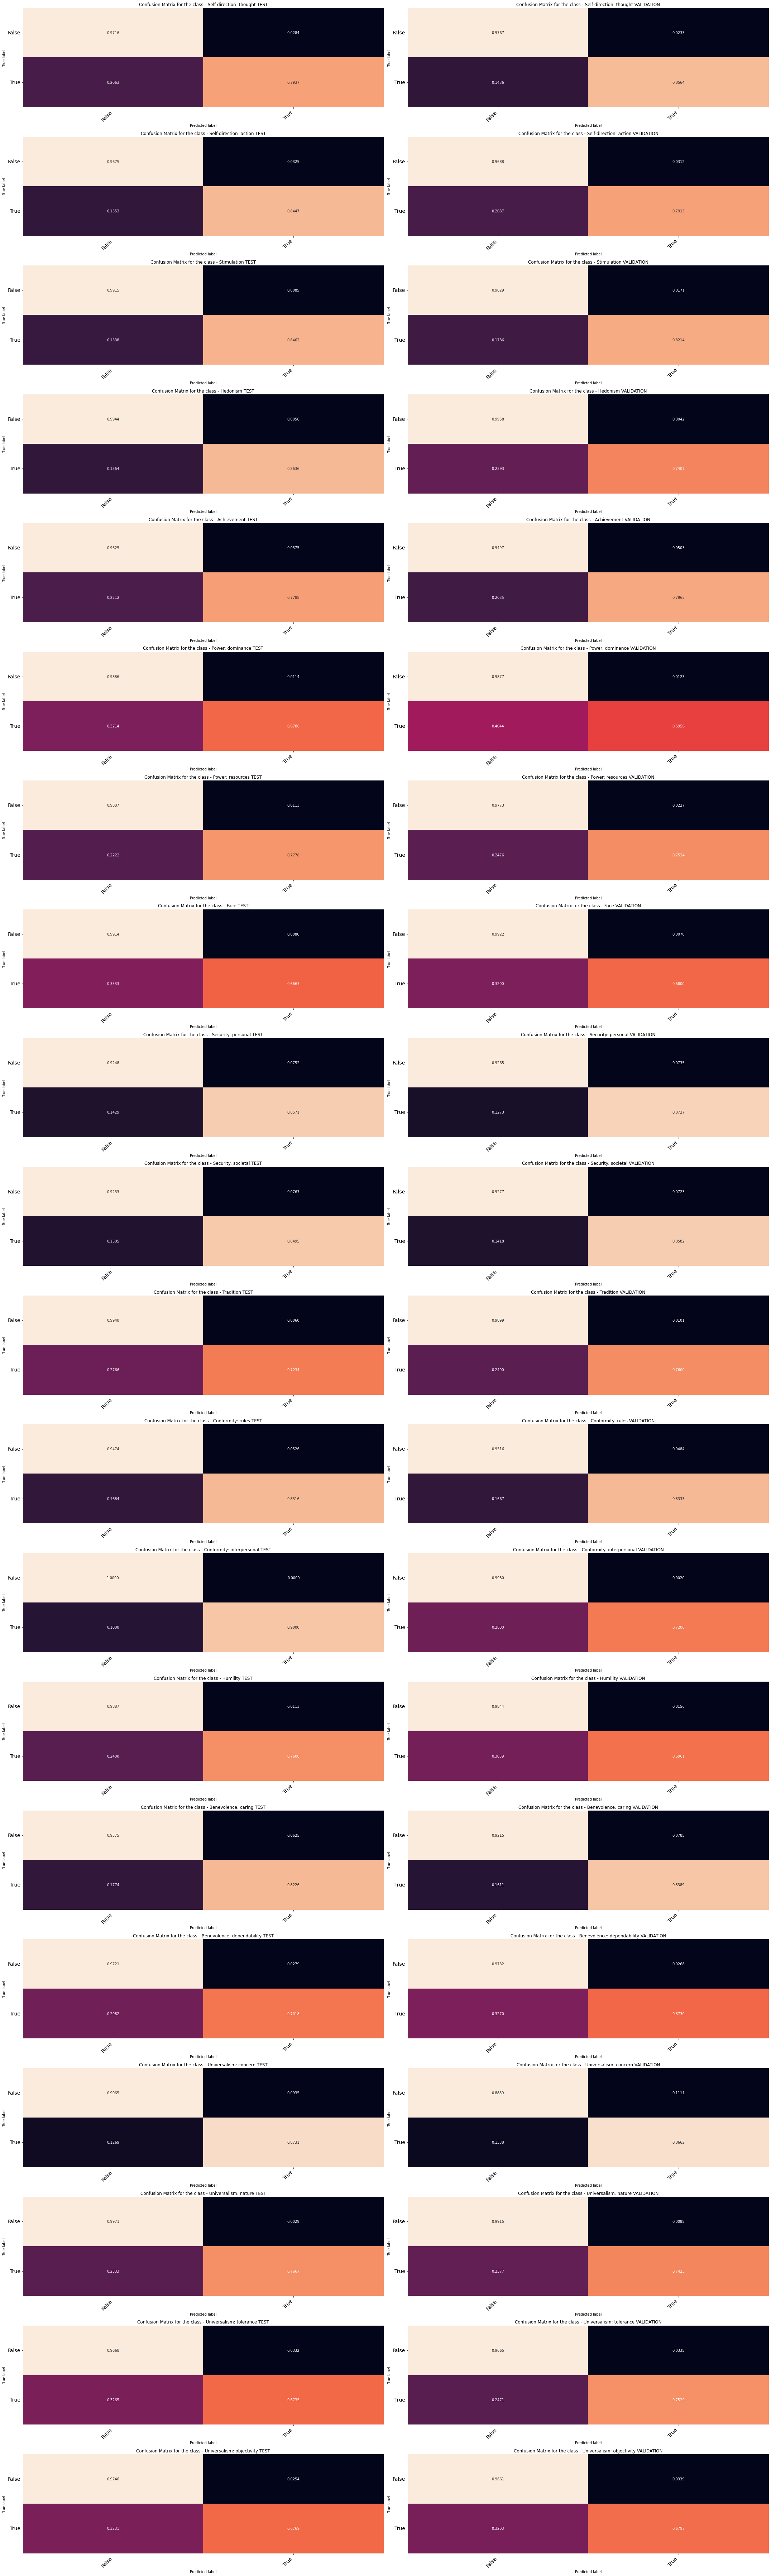

In [ ]:
fig, ax = plt.subplots(20, 2, figsize=(30, 100))

for i in range(len(labels)):
  df_test = test_cm[i].astype('float') / test_cm[i].sum(axis=1)[:, np.newaxis]
  print_confusion_matrix(
      df_test,
      ax[i][0],
      unique_labels[i],
      ["False", "True"],
      "TEST"
  )
  df_val = val_cm[i].astype('float') / val_cm[i].sum(axis=1)[:, np.newaxis]
  print_confusion_matrix(
      df_val,
      ax[i][1],
      unique_labels[i],
      ["False", "True"],
      "VALIDATION"
  )  
# for axes, cfs_matrix, label in zip(ax.flatten(), test_cm, unique_labels):
#     print_confusion_matrix(cfs_matrix, axes, label, ["False", "True"])


fig.tight_layout()
plt.show()

## F1 scores

In this section we will explore the f1 score for each class. It does not seem there is any class doing particulary better or wort than the others.

In [ ]:
f1_scores_val = f1_score(y_true=val_y_true, y_pred=val_y_pred, average=None)
f1_scores_test = f1_score(y_true=test_y_true, y_pred=test_y_pred, average=None)
f1_scores_zhihu = f1_score(y_true=zhihu_y_true, y_pred=zhihu_y_pred, average=None)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [ ]:
sorted_idx = np.argsort(labels_train_count)

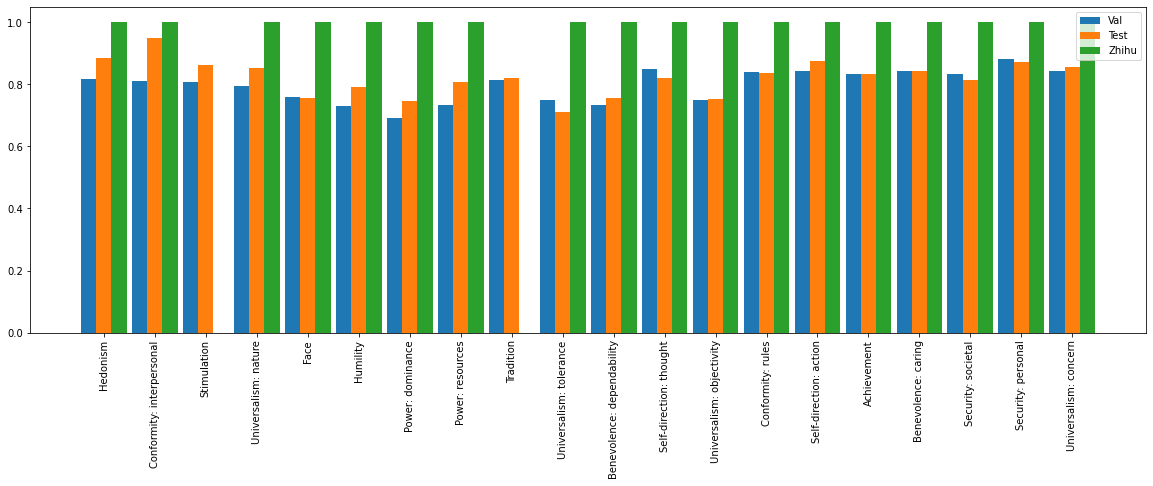

In [ ]:
plt.figure(figsize=(20,6))
X_axis = np.arange(len(unique_labels))
plt.bar(X_axis - 0.3 ,  f1_scores_val[sorted_idx], 0.3, label = "Val")
plt.bar(X_axis,  f1_scores_test[sorted_idx], 0.3, label = "Test")
plt.bar(X_axis + 0.3,  f1_scores_zhihu[sorted_idx], 0.3, label = "Zhihu")
plt.xticks(X_axis, unique_labels[sorted_idx], rotation = "vertical")
plt.legend();

This graph shows the f1-score for each label. The labels are shown in ascending order based on their frequency in the training set.

## Errors

We want to be able to see what errors are about. Hence here a random misclassificcation can easily be obtained.

In [73]:
test_y_true.shape

torch.Size([380, 20])

In [75]:
def show_error(pred, true, true_error_label=None, pred_error_label=None):
  true = true.numpy()
  error_mask = (pred[:, None] == true).all(-1).any(-1)

  # true_label_mask = np.ones((len(pred)))
  # if true_error_label is not None:
  #   true_label_mask = np.equal(true, label2id[true_error_label])
    
  # pred_label_mask = np.ones((len(pred)))
  # if pred_error_label is not None:
  #   pred_label_mask = np.equal(pred, label2id[pred_error_label])
  #   error_mask = np.logical_and(error_mask, pred_label_mask)

  # label_mask = np.logical_or(true_label_mask, pred_label_mask)
  # error_mask = np.logical_and(error_mask, pred_label_mask)
  
  false_indexes = np.argwhere(error_mask == False).reshape(-1)
  index = np.random.choice(false_indexes)
  print(f'Argument and true label\nPremise: {test_df.iloc[index, 2]}\nStance: {test_df.iloc[index, 1]}\nConclusion: {test_df.iloc[index, 0]}\n\n')
  print(f'Predicted labels: {[id2label[idx] for idx, label in enumerate(pred[index, :]) if label == 1.0]}')
  print(f'Actual labels: {[id2label[idx] for idx, label in enumerate(true[index, :]) if label == 1.0]}')

show_error(test_y_pred, test_y_true)

Argument and true label
Premise: if to a degree of reasonable certainty the state of seriousness can not be reversed by the medicine, the patient must have the right to end his life and if he needs help for that he should not be condemned
Stance: against
Conclusion: Assisted suicide should be a criminal offence


Predicted labels: ['Self-direction: action', 'Security: personal', 'Benevolence: caring', 'Universalism: tolerance']
Actual labels: ['Self-direction: action', 'Benevolence: caring', 'Universalism: concern', 'Universalism: objectivity']
